# Rate-coding with Integrate-and-Fire neurons

Here, we will go over the basic spiking neuron model, the integrate-and-fire neuron. We will be using the [Brian2](https://briansimulator.org/) simulator for designing the networks and experiments. 


In [1]:
from pylab import *
from brian2 import *
import time

In [2]:
%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif', 
                     'font.serif':['Computer Modern']})

One aspect of Brian2 that I really appreciate is its use of physical units. It is generally useful to remember the units and it helps better understand the physical relationships to the dynamical equations in the simulation. Sometimes this type of thing can be frustrating when programming, but the unit checking engine actually helps to prevent mistakes and can make debugging easier.

To that end, we are modeling neurons using the classic integrate-and-fire neuron model. When we model biological neurons, we actually use the abstraction of electronic circuits, which means that our simulation uses Maxwell's equations. Thus, we will also use physical units of electricity and values that are close to appropriate for biology. 

The essential equation for the simplified integrate-and-fire neuron is based on an RC circuit in electronics:

$$
C\frac{dV}{dt} = g_l (E_l - V) + I
$$

In this equation, $C$ (Capacitance), $E_l$ (Resting potential), and $g_l$ leak conductance, are parameters of the neuron. The state variable $V$ represents the voltage, and the variable $I$ is the input, which is taken as a current.

In [3]:
# Define the constants and equations for the neuron model

# Neuron parameters
C_Ax = 2.0 * nF # Capacitance 
g_l =  5.0 * nS # leak conductance

E_l = -60.0 * mV # Resting potential
V_t = -55.0 * mV # Threshold
V_r = -60.0 * mV # Reset

tref=0*ms # refractory period

eqs_if = Equations('''
    dV/dt = (g_l * (E_l - V) + I_ext + I_syn) / C_Ax : volt (unless refractory)
    I_ext : amp
    I_syn : amp
    ''')


## Simulating IF neurons

The integrate-and-fire neuron is just this capacitor equation with a spiking mechanism. In the most basic models, the spiking mechanism is simply a threshold. When the voltage exceeds this threshold, then the model outputs a "spike" and then the voltage is reset to a reset potential. The IF model does not actually simulate the spike dynamics. A refractory period is also often used, which forces the neuron to be inactive for a short period after a spike, but first we will start with the refractory period as 0. 

Now, we are going to simulate the neuron model and examine the firing rate for a steady current injection. To do so, we will generate a group of IF neurons and inject each of them with different amounts of current. We will then count the number of output spikes to find a relationship between current and number of spikes.



In [4]:
# Make a group of IF neurons
N_s = 50
G_post = NeuronGroup(N_s, model=eqs_if, 
                     threshold='V>V_t', 
                     reset='V=V_r', 
                     refractory=tref)

# Set initial conditions and inputs
G_post.V = E_l * ones(N_s)
# Give each neuron a different amount of input current
G_post.I_ext = np.linspace(0.0, 0.2, N_s) * nA

# Monitor the simulation
SpM_post = SpikeMonitor(G_post)
StM_post = StateMonitor(G_post, True, record=True)

# Build the simulation network
ifr_net = Network()
ifr_net.add(G_post)
ifr_net.add(SpM_post)
ifr_net.add(StM_post)

ifr_net.store('init')

In [5]:
run_time = 2.0 * second
ifr_net.restore('init')
tst = time.time()
ifr_net.run(run_time)
print("elapsed", time.time() - tst)

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.15s). [brian2.stateupdaters.base.method_choice]


elapsed 6.414305925369263


Text(0, 0.5, 'Neuron')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


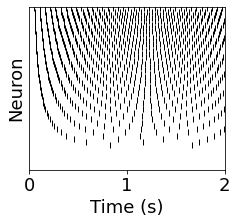

In [6]:
post_spikes = SpM_post.spike_trains()
tot_spikes = np.zeros(N_s)
ifr = np.zeros(N_s)

figure(figsize=(3.5,3))

for i in range(len(post_spikes)):
    plot(post_spikes[i] / second, i * ones(len(post_spikes[i])), '|k')
    
    if len(post_spikes[i]) > 1:
                # estimate based on total spikes during simulation
        tot_spikes[i] = len(post_spikes[i])

        # estimate based on time between spikes
        ifr[i] = 1.0 / np.mean(np.diff(post_spikes[i]))
    
ylim([0-0.5, N_s-0.5])
xlim([0, run_time/second])
yticks([])
xlabel('Time (s)')
ylabel('Neuron')

Lets take a look at the voltage dynamics of a particular neuron.

Text(0, 0.5, 'Voltage (V)')

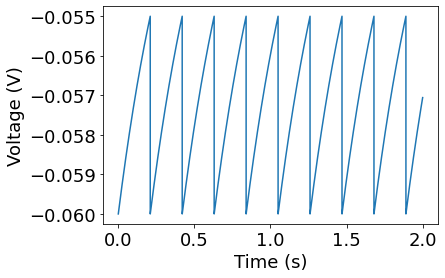

In [7]:
plot_idx = 15

plot(StM_post.t, StM_post.V[plot_idx])
xlabel('Time (s)')
ylabel('Voltage (V)')

This is a pretty simple dynamical system, and we can basically see how the simple RC circuit model is integrating the input current. Once the voltage reaches the threshold, then a spike is triggered and the voltage is instantly reset to the reset potential. 

(0.0, 0.2)

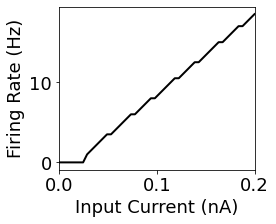

In [8]:
figure(figsize=(3.5,3))

Id = G_post.I_ext

plot(Id / nA, tot_spikes / run_time, 'k', lw=2)

xlabel('Input Current (nA)')
ylabel('Firing Rate (Hz)')
xlim([0, Id[-1]/nA])


We plotted the number of spikes during the 1-second simulation period. There seems to be a pretty simple pattern, but the result is a bit jagged. This is simply because there are some artifacts due to the way we calculated spikes per second. Basically the limited amount of simulation time leads to some rounding errors in our calculation.

As an alternative, lets estimate spikes per second based on the time between spikes for each neuron.

(0.0, 0.2)

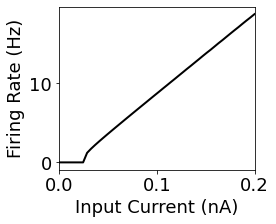

In [9]:
figure(figsize=(3.5,3))

Id = G_post.I_ext

plot(Id / nA, ifr, 'k', lw=2)

xlabel('Input Current (nA)')
ylabel('Firing Rate (Hz)')
xlim([0, Id[-1]/nA])


Now we can see clearly that the firing rate as a function of input current has some clear properties. There is a threshold below which there are no spikes. 
When we have large amounts of current, then it seems that there is a linear relationship between current and firing rate. 
We can solve some calculus problems to theoretically understand these properties.

## I&F neuron theory

We see from the simulations that the integrate-and-fire neuron model has a nearly linear input-output function -- i.e. the number of spikes per second or the spiking rate appears to be linear with respect to input current once above the threshold. If we examine the model carefully, we can see that there is a basic calculus problem we can solve that will help us theoretically understand the behavior of the neuron.


### Derivation of instantaneous-firing-rate (IFR)

To understand the relationship between firing rate and input current, we want to compute the time it takes to reach the threshold potential when starting at the reset potential when given a constant current input, $I_s$. Lets start with the differential equation for the IF neuron:

$$
C \frac{dV}{dt} = g_l (E_l - V) + I_s
$$

This is a simple enough differential equation that we can actually solve it.

First, separate the Voltage and Time terms:

$$
C\frac{dV}{g_l (E_l - V) + I_s} = dt
$$

Integrate both sides:

$$
\int C\frac{dV}{g_l (E_l - V) + I_s} = \int dt
$$

$$
- \frac{C}{g_l} \log (g_l (E_l - V) + I_s) = t + K
$$

Solve for V:

$$
g_l (E_l - V) + I_s = K e^{-\frac{g_l}{C} t}
$$

$$
V = I_s/g_l + E_l - K e^{-\frac{g_l}{C} t}
$$

(Note that above we have the constant $K$ absorb the exponential function and the division by g_l.)

We want to solve for the time it takes to reach threshold starting from the reset potential. Therefore, we will set an initial condition where $V(t=0) = V_r$. We solve for the constant K based on this initial condition.

$$
V_r = I_s/g_l + E_l - K
$$

$$
K = g_l(E_l-V_r)+I_s
$$

With this initial condition giving us the integration constant, we can next solve the equation for the time $T_{spike}$ at which the voltage exceeds the threshold $V(t=T_{spike}) = V_t$.

$$
V_t = I_s/g_l + E_l - K e^{-\frac{g_l}{C} T_{spike}}
$$

$$
\log \Big( \frac{g_l (E_l - V_t) + I_s}{g_l (E_l - V_r) + I_s} \Big) = \log e^{-\frac{g_l}{C} T_{spike}}
$$

Giving:

$$
T_{spike} = \frac{C}{g_l} \log \Big( \frac{I_s + g_l (E_l - V_r)}{I_s + g_l (E_l - V_t)} \Big)
$$

The *instantaneous-firing-rate* ($IFR$) is the inverse of $T_{spike}$:

$$
IFR = 1 / T_{spike}
$$


### Linear approximation to IFR

Nice! We now have an equation for the spiking rate given a constant input current. What a fun little calculus problem. 

We see that the plot appears to converge to a straight line, but our equation for the $IFR$ looks for from linear. How can we mathematically derive this line? 

If we want a linear apporximation of firing rate, then we need a linear formulation:

$$
\tilde{IFR} = m I_s + b
$$

To find the line, then note that the linear relationship we see in the plots only becomes linear for large values of the input current. With this, we can use a limit to compute the slope of the line:

$$
m = \lim_{I_s \to \infty} \frac{d}{dI_s} IFR
$$

I'll leave it to you to work out the calculus, this one gets pretty gnarly... Alternatively, we can just use [wolframalpha](https://www.wolframalpha.com/input/?i2d=true&i=Limit%5BD%5BDivide%5B1%2CDivide%5BC%2Cg%5Dlog%5C%2840%29Divide%5B%5C%2840%29I%2Bg*%5C%2840%29E_l-V_r%5C%2841%29%5C%2841%29%2C%5C%2840%29I%2Bg*%5C%2840%29E_l-V_t%5C%2841%29%5C%2841%29%5D%5C%2841%29%5D%2CI%5D%2CI-%3Einfinity%5D)!

This gives us a pretty simple formula for the slope of the line:

$$
m = \frac{1.0}{C (V_{t} - V_{r})}
$$

With this as the slope, we can then solve for $b$ based on:

$$
b = \lim_{I_s \to \infty} IFR - m I_s 
$$
Yes, [wolframalpha](https://www.wolframalpha.com/input/?i2d=true&i=Limit%5BDivide%5B1%2C%5C%2840%29Divide%5BC%2Cg%5D%5C%2841%29+*log%5C%2840%29Divide%5B%5C%2840%29I%2Bg*%5C%2840%29P-R%5C%2841%29%5C%2841%29%2C%5C%2840%29I%2Bg*%5C%2840%29P-T%5C%2841%29%5C%2841%29%5D%5C%2841%29%5D-Divide%5BI%2CC*%5C%2840%29T-R%5C%2841%29%5D%2CI-%3Einfinity%5D) time!
Leaving us with an equation for the offset:

$$
b = \frac{-g_l ((V_{t} - E_l) + (V_{r} - E_l))}{2C_{Ax} (V_{t} - V_{r})}
$$


In [10]:
m_ifr = 1 / (C_Ax * (V_t - V_r))
b = -g_l * (V_t + V_r - 2 * E_l) / (2*C_Ax * (V_t - V_r))


print("slope:", m_ifr, 
      "; offset:", b)

slope: 1.e+11 s^-1 A^-1 ; offset: -1.25 Hz


### Spike threshold

There is one other useful property that we can derive from the mathematics of the IF neuron, the minimum threshold for spiking. 

If we look at the formula for $T_{spike}$, we can see that if the input current $I_s$ is small then the term inside of the logarithm is negative. When this is the case, then there will be no output spikes. So it is very simple to find the minimum current $I_{min}$ needed to produce any output spikes:

$$
I_{min} + g_l (E_l - V_t) > 0
$$

$$
I_{min} > g_l (V_t - E_l)
$$

This makes intuitive sense, there must be enough current to reach the threshold potential and overcome the leakage. 

In [11]:
I_min = g_l * (V_t - E_l)
print(I_min)

25. pA


Finally, lets see how the theory fits with the simulation.

WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: divide by zero encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]
WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: invalid value encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


(0.0, 0.2)

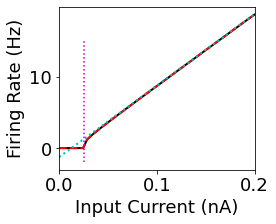

In [12]:
figure(figsize=(3.5,3))

Id = G_post.I_ext

plot(Id / nA, ifr / second, 'k', lw=2)

t_spike = C_Ax / g_l * np.log((Id+g_l*(E_l - V_r))/(Id+g_l*(E_l - V_t)))
fr = 1/t_spike
fr[isnan(fr)] = 0

plot(Id/nA, fr / second, '--r', lw=2)


#Ish = np.linspace(0, G_post.I_ext[-1]/nA, 500) * nA

plot(Id/nA, (m_ifr * Id + b), ':c', lw=2)

plot([I_min, I_min]/nA, [-2, 15], ':m')


xlabel('Input Current (nA)')
ylabel('Firing Rate (Hz)')
xlim([0, Id[-1]/nA])


## IF neuron with refractory period

One final thing we can examine is the refractory period. The refractory period has long been observed in neuroscience, where after spiking the neuron is unresponsive to inputs. This is typically due to the dynamics of the channels during a biophysical spike. When using integrate-and-fire neurons, the refractory period is simply a period where the dynamics of the neuron are clamped to the reset potential. Its very simple to add a refractory period to a neuron in Brian2.

In [13]:
tref = 50*ms

In [14]:
# Make a group of IF neurons
N_s = 50
G_post = NeuronGroup(N_s, model=eqs_if, 
                     threshold='V>V_t', 
                     reset='V=V_r', 
                     refractory=tref)

# Set initial conditions and inputs
G_post.V = E_l * ones(N_s)
G_post.I_ext = np.linspace(0.0, 0.5, N_s) * nA

# Monitor the simulation
SpM_post = SpikeMonitor(G_post)
StM_post = StateMonitor(G_post, True, record=True)

# Build the simulation network
ifr_net = Network()
ifr_net.add(G_post)
ifr_net.add(SpM_post)
ifr_net.add(StM_post)

ifr_net.store('init')

In [15]:
run_time = 2.0 * second
ifr_net.restore('init')
tst = time.time()
ifr_net.run(run_time)
print("elapsed", time.time() - tst)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.05s). [brian2.stateupdaters.base.method_choice]


elapsed 5.269563913345337


Text(0, 0.5, 'Neuron')

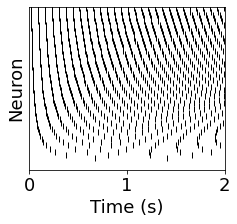

In [16]:
post_spikes = SpM_post.spike_trains()
tot_spikes = np.zeros(N_s)
ifr = np.zeros(N_s)

figure(figsize=(3.5,3))

for i in range(len(post_spikes)):
    plot(post_spikes[i] / second, i * ones(len(post_spikes[i])), '|k')
    
    if len(post_spikes[i]) > 1:
                # estimate based on total spikes during simulation
        tot_spikes[i] = len(post_spikes[i])

        # estimate based on time between spikes
        ifr[i] = 1.0 / np.mean(np.diff(post_spikes[i]))
    
ylim([0-0.5, N_s-0.5])
xlim([0, run_time/second])
yticks([])
xlabel('Time (s)')
ylabel('Neuron')

### IFR theory with refractory period

Including the refractory period $\tau_{ref}$ is quite simple in our theoretical analysis. We just add the refractory period to the formula for $T_{spike}$:

$$
T_{spike} = \frac{C}{g_l} \log \Big( \frac{I_s + g_l (E_l - V_r)}{I_s + g_l (E_l - V_t)} \Big) + \tau_{ref}
$$

However, it should be obvious that this new formula will not continue to converge to a straight line. Rather, the refractory period causes the spiking rate to saturate to a maximum. This maximum spike rate is simply:

$$
IFR_{max} = 1/\tau_{ref}
$$

In [17]:
ifr_max = 1/tref

WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: divide by zero encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]
WARNING    /opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: invalid value encountered in log
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


(-5.0, 30.0)

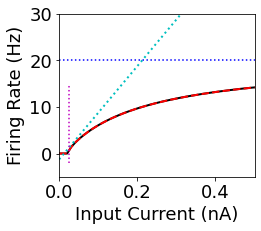

In [18]:
figure(figsize=(3.5,3))

Id = G_post.I_ext

plot(Id / nA, ifr / second, 'k', lw=2)

t_spike = C_Ax / g_l * np.log((Id+g_l*(E_l - V_r))/(Id+g_l*(E_l - V_t))) + tref
fr = 1/t_spike
fr[isnan(fr)] = 0

plot(Id/nA, fr / second, '--r', lw=2)


#Ish = np.linspace(0, G_post.I_ext[-1]/nA, 500) * nA

plot(Id/nA, (m_ifr * Id + b), ':c', lw=2)

plot([I_min, I_min]/nA, [-2, 15], ':m')

plot([Id[:].min(), Id[:].max()]/nA, [ifr_max, ifr_max], ':b')


xlabel('Input Current (nA)')
ylabel('Firing Rate (Hz)')
xlim([0, Id[-1]/nA])
ylim([-5, 30])


## Conclusions

We covered here how we can formalize the integrate-and-fire neuron into a reliable mathematical model where information is represented by the firing rate of the spikes. We were able to derive an equation, the $IFR$, that computes the firing rate based on the input current and the parameters of the neuron model. We also showed that this function is rectified linear when there is no refractory period, and that it is saturating when there is a refractory period, and we analyzed useful approximations to have a mathematical grasp on the behavior of IF neurons.

The analysis done here required the assumption that the inputs to the neurons are static. But is this useful then when the inputs are changing as data comes in from sensors? This is a type of approximation that is often used in control theory, where we can define a regime in which the equations are valid based on dynamics that are occuring at different time-scales. In this case, we are assuming that the input changes slowly compared to the spiking output. Effectively the input is band-limited and lower than the maximum spiking frequency. We can be sure of such situations based on the timeconstants of the neurons and synapses.

But what if the inputs are fast compared to the neurons? Well, in this case we must rely on a different theory, and this regime is outside the scope of the $IFR$ theory. 

To fully connect the dynamics of integrate-and-fire neurons to connectionist theory, we must also exmaine how spikes interact with synapses and how these are integrated to perform computations like the dot-product. In the next section, we will explore exactly how IF models can be used to compute the dot-product and fully tie-in basic spiking models into connectionist theory. 